In [1]:
import edge_sensor
import labbench as lb
import channel_analysis
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import iqwaveform
from edge_sensor.api import captures, iq_corrections
import cupy as cp
from SoapySDR import SOAPY_SDR_RX, SOAPY_SDR_TX
import uuid
import gc

lb.show_messages('debug')

if 'sdr' not in locals():
    sdr = edge_sensor.radios.Air7201B()
    # sdr = edge_sensor.radios.NullSource()

sweep = edge_sensor.read_yaml_sweep('run.yaml')

data = []

with sdr:
    # print('hardware info: ', dict(sdr.backend.getHardwareInfo()))
    # print('hardware key: ', sdr.backend.getHardwareKey())
    # print('driver key: ', sdr.backend.getDriverKey())
    # print('has DC offset mode: ', sdr.backend.hasDCOffsetMode(SOAPY_SDR_RX, 0))

    id_ = sdr.id
    sdr.setup(sweep.radio_setup)

    for capture in sweep.captures:
        with lb.stopwatch('acquire'):
            iq, acquired_capture = sdr.acquire(capture, correction=False)

        with lb.stopwatch('resample'):
            iq = iq_corrections.resampling_correction(iq, capture, sdr)

        with lb.stopwatch('analyze'):
            analysis = channel_analysis.analyze_by_spec(
                iq, capture, spec=sweep.channel_analysis, expand_dims=('capture',)
            )
            del iq

        with lb.stopwatch('package to xarray'):
            coords = captures.build_coords(
                capture,
                output=sweep.output,
                radio_id=id_,
                sweep_time=acquired_capture.start_time,
            )

            analysis = analysis.assign_coords(coords)

 INFO   2025-01-07 12:07:46.460 • Air7201B(): opened with SoapyAIRT
 DEBUG  2025-01-07 12:07:47.294 • labbench: setup stream for channels [0, 1] 0.831 s elapsed
 DEBUG  2025-01-07 12:07:47.296 • Air7201B(): opened
 DEBUG  2025-01-07 12:07:47.299 • Air7201B(): id → '48b02d483d95'
 DEBUG  2025-01-07 12:07:47.302 • Air7201B(): channel → ()
 DEBUG  2025-01-07 12:07:47.304 • Air7201B(): PosixPath('cal.p')  → calibration
 DEBUG  2025-01-07 12:07:47.306 • Air7201B(): 0.01  → periodic_trigger
 DEBUG  2025-01-07 12:07:47.308 • Air7201B(): False  → gapless_repeats
 DEBUG  2025-01-07 12:07:47.310 • Air7201B(): False  → time_sync_every_capture
 DEBUG  2025-01-07 12:07:47.316 • Air7201B(): 'except'  → on_overflow
 DEBUG  2025-01-07 12:07:47.318 • Air7201B(): 'internal'  → time_source
 DEBUG  2025-01-07 12:07:47.320 • Air7201B(): time_source → 'internal'


press enter 


 DEBUG  2025-01-07 12:07:48.855 • Air7201B(): 0.1 (s) → duration
 DEBUG  2025-01-07 12:07:48.857 • Air7201B(): (0, 1)  → channel
 DEBUG  2025-01-07 12:07:48.860 • Air7201B(): gain → (-30.0,)  (dB)
 DEBUG  2025-01-07 12:07:48.862 • Air7201B(): set channel 0 gain: 0.0 dB
 DEBUG  2025-01-07 12:07:48.866 • Air7201B(): set channel 1 gain: 0.0 dB
 DEBUG  2025-01-07 12:07:48.868 • Air7201B(): (0.0,) (dB) → gain
 DEBUG  2025-01-07 12:07:48.883 • Air7201B(): sample_rate → 31250000.0
 DEBUG  2025-01-07 12:07:48.885 • Air7201B(): backend_sample_rate → 31250000.0  (Hz)
 DEBUG  2025-01-07 12:07:48.889 • Air7201B(): 125000000.0  → sample_rate
 DEBUG  2025-01-07 12:07:48.891 • Air7201B(): 125000000.0 (Hz) → backend_sample_rate
 DEBUG  2025-01-07 12:07:48.893 • Air7201B(): 0.9300595238095238  → _downsample
 DEBUG  2025-01-07 12:07:48.895 • Air7201B(): sample_rate → 125000000.0
 DEBUG  2025-01-07 12:07:48.897 • Air7201B(): backend_sample_rate → 125000000.0  (Hz)
 DEBUG  2025-01-07 12:07:48.899 • Air720

ValueError: error building xarray PersistenceSpectrum.baseband_frequency

1. with fft plan cache:
    - run 1: 2289024 MB free, 4.964 s resample, 0.903 s spectrogram, 1s total analysis
    - run 2: 1840824 MB free, 0.640 s resample, 0.108 s spectrogram histogram, 0.368 s total analysi

2. without fft plan cache:
    - run 1: 2674872 MB free, 4.833 s resample, 0.901 s spectrogram, 1s total analysis
    - run 2: 2657760 MB free, 0.488 s resample, 0.098 s spectrogram histogram, 0.383 s total analysis

3. without fft plan cache, pinned memory
    - run 1: 2212376 MB free, 4.109 s resample, 0.898 s spectrogram_histogram, 0.992s total analysis
    - run 2: 2189836 MB free, 0.25 s resample, 0.100 s spectrogram histogram, 0.391s total analysis

4. without fft plan cache, pinned memory, no memory pools
    - run 1: 4741708 MB free, 4.25 s resample, 0.954 s spectrogram_histogram, 1.078s total analysis
    - run 2: 2189836 MB free, 1.075 s resample, 0.146 s spectrogram histogram, 0.222s total analysis

5. without fft plan cache, pinned memory, only non-pinned memory pools
    - run 1: 4741708 MB free, 3.597 s resample, 0.897 s spectrogram_histogram, 0.994 total analysis
    - run 2: 2189836 MB free, 1.075 s resample, 0.146 s spectrogram histogram, 0.222s total analysis

6. without fft plan cache, pinned memory, only non-pinned memory pools, free memory 2x during resample
    - start: 5730252 MB free
    - run 1: 4741708 MB free, 4.023 s resample, 0.91 s spectrogram_histogram, 1.028 total analysis
    - run 2: 3584008 MB free, 0.934 s resample, 0.115 s spectrogram histogram, 0.169 total analysis

7. without fft plan cache, pinned memory, only non-pinned memory pools, free memory 1x during resample (at end)
    - start: 5746152 MB free
    - run 1: 3605548 MB free, 4.023 s resample, 0.91 s spectrogram_histogram, 1.028 total analysis
    - run 2: 3569332 MB free, 1.127 s resample, 0.115 s spectrogram histogram, 0.169 total analysis

8. without fft plan cache, pinned memory, only non-pinned memory pools, free memory 1x during resample (after stft)
    - start: 4593472 MB free
    - run 1: 3275688 MB free, 3.427 s resample, 0.91 s spectrogram_histogram, 0.971 total analysis
    - run 2: 3167600 MB free, 0.521 s resample, 0.115 s spectrogram histogram, 0.328 total analysis

9. without fft plan cache, pinned memory, no non-pinned memory pools, buffering
    - start: 5528172 MB free
    - run 1: 3275688 MB free, 5.375 s resample, 1.083 total analysis
    - run 2: 3167600 MB free, 2.136 s resample, 0.215 total analysis

10. without fft plan cache, pinned memory, only non-pinned memory pools, disable non-pinned memory during resample
    - start: 5504596 MB free
    - run 1: 3703524 MB free, 4.249 s resample, 1.083 total analysis
    - run 2: 3167600 MB free, 1.130 s resample, 0.328 total analysis

11. without fft plan cache, pinned memory, only non-pinned memory pools, 3x force gc collects gen 2
    - start: 5644876 MB free
    - run 1: 3994188 MB free, 4.249 s resample, 1.072 total analysis
    - run 2: 3971628 MB free, 1.644 s resample, 0.208 total analysis

12. without fft plan cache, pinned memory, only non-pinned memory pools, 3x force gc collects gen 0
    - start: 5617120 MB free
    - run 1: 3904192 MB free, 4.249 s resample, 1.072 total analysis
    - run 2: 3971628 MB free, 1.053 s resample, 0.208 total analysis

13. without fft plan cache, pinned memory, only non-pinned memory pools, 1x force gc collects gen 0 (after iq copy)
    - start: 5617120 MB free
    - run 1: 3904192 MB free, 4.249 s resample, 1.072 total analysis
    - run 2: 3971628 MB free, 1.053 s resample, 0.208 total analysis

14. without fft plan cache, pinned memory, only non-pinned memory pools, 1x force gc collects gen 0 (after xstft)
    - start: 5617120 MB free
    - run 1: 3904192 MB free, 4.249 s resample, 1.072 total analysis
    - run 2: 3971628 MB free, 1.053 s resample, 0.208 total analysis

15. without fft plan cache, pinned memory, only non-pinned memory pools, 1x force gc collects gen 0 (at end)
    - start: 5617120 MB free
    - run 1: 3904192 MB free, 4.249 s resample, 1.072 total analysis
    - run 2: 3971628 MB free, 1.053 s resample, 0.208 total analysis

16. without fft plan cache, pinned memory, only non-pinned memory pools, gc collects gen 0 before resample
    - start: 5617120 MB free
    - run 1: 3904192 MB free, 4.249 s resample, 1.072 total analysis
    - run 2: 3971628 MB free, 1.053 s resample, 0.208 total analysis

In [8]:
mempool = cp.get_default_memory_pool()
# You can access statistics of these memory pools.
print(mempool.used_bytes())              # 0
print(mempool.total_bytes())             # 0
print(mempool.n_free_blocks())    # 0
mempool.free_byte

596992
751104
2


In [7]:
mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()


In [2]:
spec = iqwaveform.envtodB(np.fft.fftshift(np.fft.fft(iq, axis=1)))
freqs = np.fft.fftshift(np.fft.fftfreq(spec.shape[1], 1 / 134.4e6))

NameError: name 'iq' is not defined

In [3]:
plt.plot(freqs / 1e6, spec[0], rasterized=True)

NameError: name 'freqs' is not defined

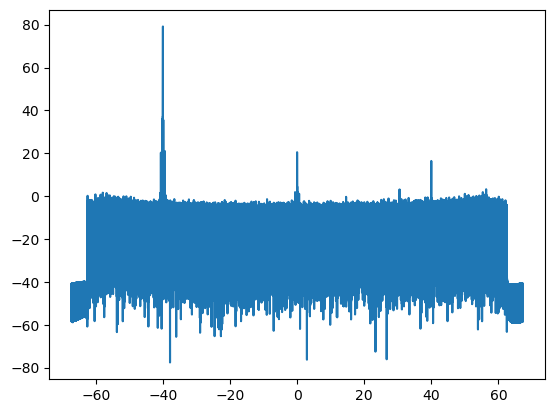

In [16]:
plt.plot(freqs / 1e6, spec[1], rasterized=True)

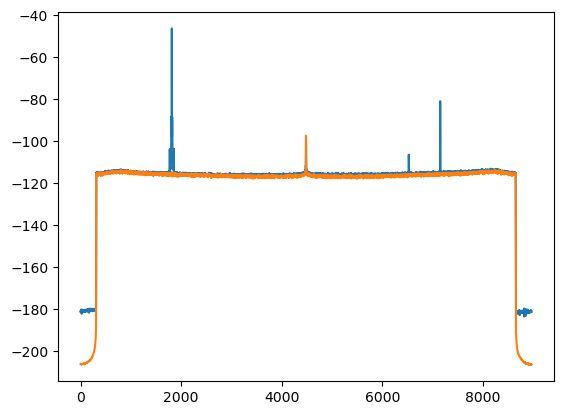

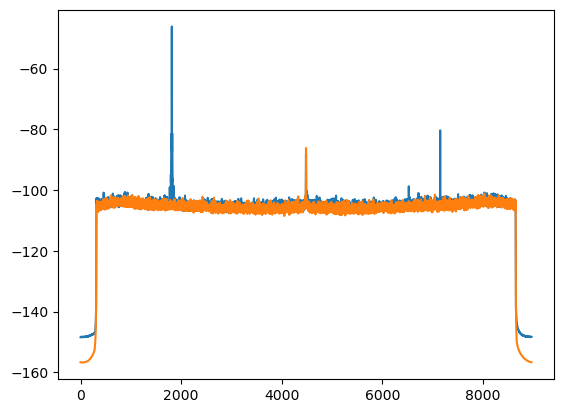

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import iqwaveform

plt.plot(analysis['persistence_spectrum'][:, 0].T)

plt.subplots()
plt.plot(analysis['persistence_spectrum'][:, -1].T)

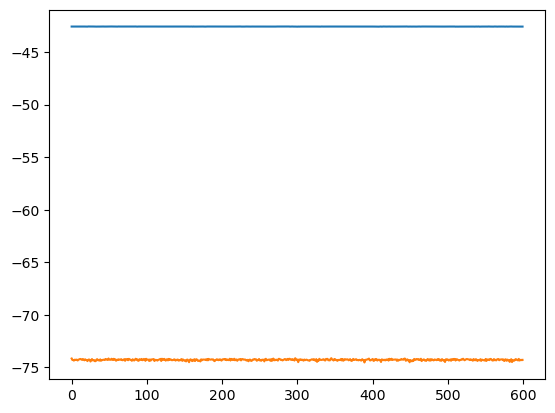

In [12]:
plt.plot(analysis['cyclic_channel_power'][0][0].T)

In [ ]:
# import importlib

# from channel_analysis import config
# config = importlib.reload(config)

# from channel_analysis import dataarrays
# waveform = importlib.reload(waveform)
# waveform.config = config

# analysis_spec = {
#     'channel_power_time_series': {
#         'detector_period': 10e-3,
#         'power_detectors': ('rms', 'peak')
#     },
#     'cyclic_channel_power': {
#         'cyclic_period': 10e-3,
#         'detector_period': 1e-3 / 15 / 4,
#         'power_detectors': ('rms', 'peak'),
#         'cyclic_statistics': ('min', 'mean', 'max'),
#     },
#     'persistence_spectrum': {
#         'window': 'flattop',
#         'frequency_resolution':15e3,
#         'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
#         'truncate': True
#     },
#     'channel_power_ccdf': {
#         'power_low': -105,
#         'power_high': -60,
#         'power_resolution': 221,  # 0.25 dB resolution
#     },
#     # 'iq_waveform': {
#     #     'start_time_sec': 0,
#     #     'stop_time_sec': 100e-3
#     # }
# }

# filter_spec = {}

# data = waveform.from_spec(
#     iq,
#     sdr,
#     analysis_spec=analysis_spec,
# )

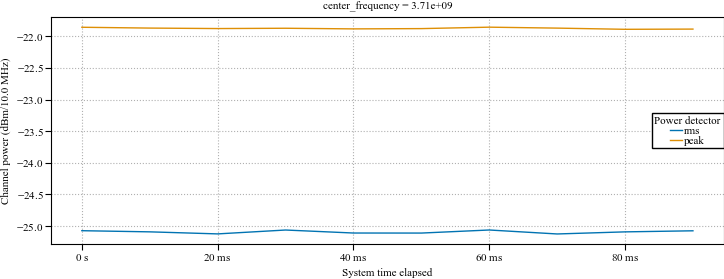

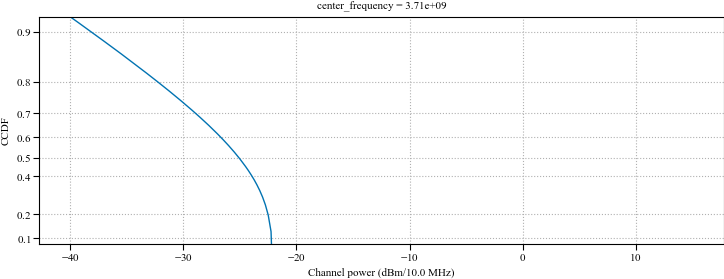

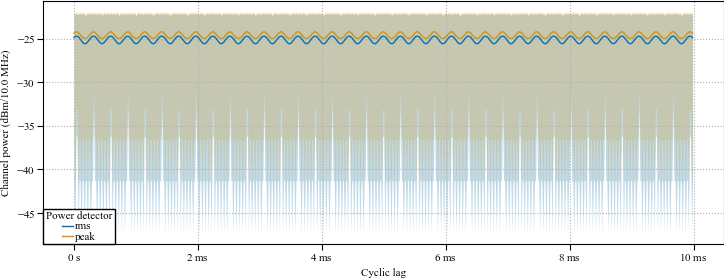

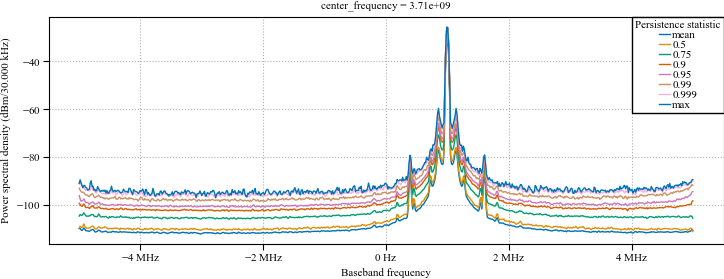

In [ ]:
import iqwaveform
from channel_analysis import figures
import matplotlib.pyplot as plt
from iqwaveform import powtodB

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()
pvt = data.power_time_series.sel(center_frequency=3710e6)
pvt.plot.line(x='time_elapsed', ax=ax)
figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

fig, ax = plt.subplots()
apd = data.amplitude_probability_distribution.sel(center_frequency=3710e6)
apd.plot.line(x='channel_power_bin', ax=ax)
ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power_bin', tick_units=False)
figures.label_axis(ax.yaxis, apd)

fig, ax = plt.subplots()
cyclic_power = data.cyclic_channel_power.sel(center_frequency=3710e6)
time = cyclic_power.cyclic_lag
for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)
    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)
    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

fig, ax = plt.subplots()
spectrum = data.persistence_spectrum.sel(center_frequency=3710e6)
spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
figures.label_axis(ax.yaxis, spectrum, tick_units=False)
figures.label_legend(ax, spectrum, 'persistence_statistic')

In [1]:
import functools
import xarray as xr
from edge_sensor.api import structs
from edge_sensor.api import captures
import pandas as pd
import typing
import importlib

coords = captures.build_coords(
    capture,
    output=sweep.output,
    radio_id=id_,
    sweep_time=acquired_capture.start_time,
)

analysis.assign_coords(coords)

NameError: name 'capture' is not defined